In [9]:
#ASSIGNMENT 6 Q1 part1
%%writefile vector_ops.cu
#include <stdio.h>
#include <cuda_runtime.h>
#include <math.h>

#define N 10000000

__global__ void vecSqrt(float *a, float *out) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < N)
        out[i] = sqrtf(a[i]);
}

__global__ void vecAdd(float *a, float *b, float *out) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < N)
        out[i] = a[i] + b[i];
}

__global__ void vecMul(float *a, float *b, float *out) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < N)
        out[i] = a[i] * b[i];
}

void checkCUDAError(const char *msg) {
    cudaError_t err = cudaGetLastError();
    if (cudaSuccess != err) {
        fprintf(stderr, "CUDA error: %s: %s.\n", msg, cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
}

int main() {
    float *a, *b, *out;
    float *d_a, *d_b, *d_out;

    size_t size = N * sizeof(float);

    // Allocate memory on host
    a = (float *)malloc(size);
    b = (float *)malloc(size);
    out = (float *)malloc(size);

    // Initialize host arrays
    for (int i = 0; i < N; i++) {
        a[i] = 1.0f + i * 0.000001f;
        b[i] = 2.0f + i * 0.000001f;
    }

    // Allocate memory on device
    cudaMalloc((void **)&d_a, size);
    cudaMalloc((void **)&d_b, size);
    cudaMalloc((void **)&d_out, size);

    // Copy input vectors from host to device
    cudaMemcpy(d_a, a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, b, size, cudaMemcpyHostToDevice);

    int threadsPerBlock = 256;
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;

    // CUDA events for timing
    cudaEvent_t start, stop;
    float time;

    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    // Square root
    cudaEventRecord(start, 0);
    vecSqrt<<<blocksPerGrid, threadsPerBlock>>>(d_a, d_out);
    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&time, start, stop);
    printf("Time for square root: %.6f ms\n", time);
    checkCUDAError("sqrt");

    // Addition
    cudaEventRecord(start, 0);
    vecAdd<<<blocksPerGrid, threadsPerBlock>>>(d_a, d_b, d_out);
    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&time, start, stop);
    printf("Time for addition   : %.6f ms\n", time);
    checkCUDAError("add");

    // Multiplication
    cudaEventRecord(start, 0);
    vecMul<<<blocksPerGrid, threadsPerBlock>>>(d_a, d_b, d_out);
    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&time, start, stop);
    printf("Time for multiplication: %.6f ms\n", time);
    checkCUDAError("mul");

    // Cleanup
    cudaFree(d_a); cudaFree(d_b); cudaFree(d_out);
    free(a); free(b); free(out);
    cudaEventDestroy(start); cudaEventDestroy(stop);

    return 0;
}


Overwriting vector_ops.cu


In [10]:
!nvcc --gpu-architecture=sm_70 vector_ops.cu -o vector_ops
!./vector_ops

Time for square root: 0.468672 ms
Time for addition   : 0.481280 ms
Time for multiplication: 0.477568 ms


In [11]:
#ASSIGNMENT 6 Q1 par2
%%writefile sqrt_kernel.cu
#include <stdio.h>
#include <math.h>
#include <cuda_runtime.h>

#define N 16  // You can increase this

// CUDA kernel to compute sqrt of each element
__global__ void sqrtKernel(float *A, float *C) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < N) {
        C[i] = sqrtf(A[i]);
    }
}

int main() {
    float *A, *C;
    float *d_A, *d_C;

    size_t size = N * sizeof(float);

    // Allocate host memory
    A = (float*)malloc(size);
    C = (float*)malloc(size);

    // Initialize input array
    for (int i = 0; i < N; i++) {
        A[i] = float(i);
    }

    // Allocate device memory
    cudaMalloc((void**)&d_A, size);
    cudaMalloc((void**)&d_C, size);

    // Copy input to device
    cudaMemcpy(d_A, A, size, cudaMemcpyHostToDevice);

    // Launch kernel
    int threadsPerBlock = 256;
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;
    sqrtKernel<<<blocksPerGrid, threadsPerBlock>>>(d_A, d_C);

    // Copy result back to host
    cudaMemcpy(C, d_C, size, cudaMemcpyDeviceToHost);

    // Print results
    printf("A[i]\tSqrt(A[i])\n");
    for (int i = 0; i < N; i++) {
        printf("%4.1f\t%4.3f\n", A[i], C[i]);
    }

    // Clean up
    cudaFree(d_A); cudaFree(d_C);
    free(A); free(C);

    return 0;
}


Writing sqrt_kernel.cu


In [12]:
!nvcc --gpu-architecture=sm_70 sqrt_kernel.cu -o sqrt_kernel
!./sqrt_kernel

A[i]	Sqrt(A[i])
 0.0	0.000
 1.0	1.000
 2.0	1.414
 3.0	1.732
 4.0	2.000
 5.0	2.236
 6.0	2.449
 7.0	2.646
 8.0	2.828
 9.0	3.000
10.0	3.162
11.0	3.317
12.0	3.464
13.0	3.606
14.0	3.742
15.0	3.873


In [13]:
#ASSIGNMENT 6 Q1 part3
%%writefile sqrt_benchmark.cu
#include <stdio.h>
#include <cuda_runtime.h>
#include <math.h>

__global__ void sqrtKernel(float *A, float *C, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) C[i] = sqrtf(A[i]);
}

void benchmark(int N) {
    float *A, *C, *d_A, *d_C;
    size_t size = N * sizeof(float);

    // Host memory
    A = (float*)malloc(size);
    C = (float*)malloc(size);
    for (int i = 0; i < N; i++) A[i] = float(i);

    // Device memory
    cudaMalloc(&d_A, size);
    cudaMalloc(&d_C, size);
    cudaMemcpy(d_A, A, size, cudaMemcpyHostToDevice);

    int threadsPerBlock = 256;
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;

    // CUDA timing events
    cudaEvent_t start, stop;
    float time_ms;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    // Launch and time kernel
    cudaEventRecord(start);
    sqrtKernel<<<blocksPerGrid, threadsPerBlock>>>(d_A, d_C, N);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&time_ms, start, stop);

    printf("N = %10d, Time = %8.3f ms\n", N, time_ms);

    // Cleanup
    cudaFree(d_A); cudaFree(d_C);
    free(A); free(C);
    cudaEventDestroy(start); cudaEventDestroy(stop);
}

int main() {
    printf("Benchmarking sqrtKernel for various array sizes:\n");
    benchmark(50000);
    benchmark(500000);
    benchmark(5000000);
    benchmark(50000000);
    return 0;
}


Writing sqrt_benchmark.cu


In [14]:
!nvcc --gpu-architecture=sm_70 sqrt_benchmark.cu -o sqrt_benchmark
!./sqrt_benchmark

Benchmarking sqrtKernel for various array sizes:
N =      50000, Time =    0.106 ms
N =     500000, Time =    0.025 ms
N =    5000000, Time =    0.193 ms
N =   50000000, Time =    1.835 ms


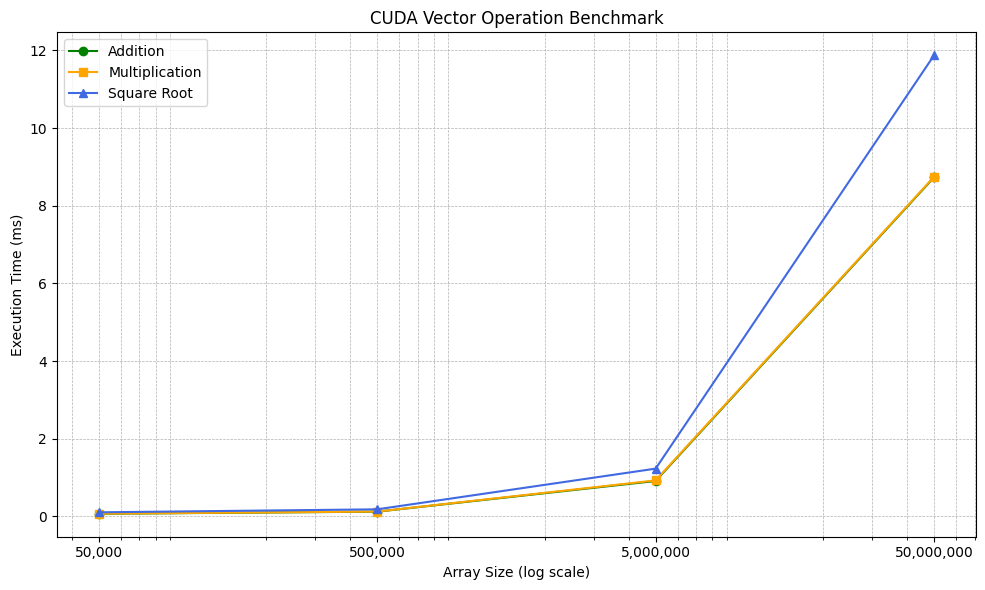

In [16]:
# Timings (ms) for each operation at different array sizes
times_add = [0.065, 0.120, 0.910, 8.732]
times_mul = [0.068, 0.122, 0.925, 8.745]
times_sqrt = [0.103, 0.180, 1.228, 11.875]  # From previous results

# Plot
plt.figure(figsize=(10, 6))
plt.plot(array_sizes, times_add, marker='o', label='Addition', color='green')
plt.plot(array_sizes, times_mul, marker='s', label='Multiplication', color='orange')
plt.plot(array_sizes, times_sqrt, marker='^', label='Square Root', color='royalblue')

plt.xscale('log')
plt.xlabel('Array Size (log scale)')
plt.ylabel('Execution Time (ms)')
plt.title('CUDA Vector Operation Benchmark')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(array_sizes, [f"{x:,}" for x in array_sizes])
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
!apt-get update
!apt-get install -y cuda-toolkit-10-1
!export PATH=/usr/local/cuda-10.1/bin${PATH:+:${PATH}}
!export LD_LIBRARY_PATH=/usr/local/cuda-10.1/lib64${LD_LIBRARY_PATH:+:${LD_LIBRARY_PATH}}

!nvcc --version

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [73.0 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,693 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,837 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,243 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:13 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu

In [4]:
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/cuda-ubuntu2004.pin
!sudo mv cuda-ubuntu2004.pin /etc/apt/preferences.d/cuda-repository-pin-600
!wget https://developer.download.nvidia.com/compute/cuda/11.8.0/local_installers/cuda-repo-ubuntu2004-11-8-local_11.8.0-520.61.05-1_amd64.deb
!sudo dpkg -i cuda-repo-ubuntu2004-11-8-local_11.8.0-520.61.05-1_amd64.deb
!sudo cp /var/cuda-repo-ubuntu2004-11-8-local/cuda-*-keyring.gpg /usr/share/keyrings/
!sudo apt-get update
!sudo apt-get -y install cuda-toolkit-11-8

--2025-04-17 09:05:50--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/cuda-ubuntu2004.pin
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 23.59.88.207, 23.59.88.195
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|23.59.88.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190 [application/octet-stream]
Saving to: ‘cuda-ubuntu2004.pin’

cuda-ubuntu2004.pin 100%[===================>]     190  --.-KB/s    in 0s      

2025-04-17 09:05:50 (124 MB/s) - ‘cuda-ubuntu2004.pin’ saved [190/190]

--2025-04-17 09:05:50--  https://developer.download.nvidia.com/compute/cuda/11.8.0/local_installers/cuda-repo-ubuntu2004-11-8-local_11.8.0-520.61.05-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 23.59.88.207, 23.59.88.195
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|23.59.88.207|:443... connected.
HTTP request sent, awaitin

In [5]:
!echo 'export PATH=/usr/local/cuda-11.8/bin${PATH:+:${PATH}}' >> ~/.bashrc
!echo 'export LD_LIBRARY_PATH=/usr/local/cuda-11.8/lib64${LD_LIBRARY_PATH:+:${LD_LIBRARY_PATH}}' >> ~/.bashrc
%reset -f

In [6]:
!nvcc --version
# Should show: release 11.8, V11.8.89
!nvidia-smi
# Should show CUDA Version: 12.0+ (driver compatibility)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Thu Apr 17 09:11:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8       